In [72]:
import requests
import hashlib
import time
import datetime
from google.colab import userdata
import pandas as pd
import sqlite3
import seaborn as sns
import numpy as np

In [73]:
public_key=userdata.get('public_key_marvel')
private_key=userdata.get('private_key_marvel')

In [74]:
DB_NAME = 'banco_marvel.db'
MAX_RETRIES = 3  # Tentativas por requisição
DELAY = 1  # Atraso entre requisições em segundos
DEFAULT_LIMIT = 100
BASE_TIMEOUT = 10

# Requisição manual para testes

In [ ]:
timestamp = str(time.time())
md5_hash= timestamp + private_key + public_key
md5_hash = hashlib.md5(md5_hash.encode("utf-8")).hexdigest()
# Modifique a URL para o endpoint de personagens
url = f"https://gateway.marvel.com/v1/public/series?ts={timestamp}&apikey={public_key}&hash={md5_hash}"
print(url)
# Código de tratamento dos dados
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print(f"Total de personagens: {data['data']['total']}")
    for char in data['data']['results']:
        print(char)

# Criação banco de dados

In [109]:
# with sqlite3.connect(DB_NAME) as conn:
#     cursor = conn.cursor()

#     # Executar consulta para dropar a tabela series
#     cursor.execute('''
#         DROP TABLE IF EXISTS series;
#     ''')

In [110]:
 # Função para criar o banco
def create_database():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Tabela Personagens
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela Comics
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS comics (
        id INTEGER PRIMARY KEY,
        digital_id INTENGER,
        title TEXT NOT NULL,
        issue_number INTEGER,
        description TEXT,
        variant_description TEXT,
        modified TEXT,
        format TEXT,
        page_count INTEGER,
        series_URI TEXT,
        series_name TEXT,
        price REAL,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS series (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        start_year INTEGER,
        end_year INTEGER,
        rating TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        start TEXT,
        end TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela de relacionamento characters e events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_events (
        id_character INTEGER,
        id_event INTEGER,
        PRIMARY KEY(id_character, id_event),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_event) REFERENCES events(id)
    )''')

    # Tabela de relacionamento characters e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_series (
        id_character INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_character, id_serie),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    # Tabela de relacionamento events e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events_series (
        id_event INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_event, id_serie),
        FOREIGN KEY(id_event) REFERENCES events(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    conn.commit()
    conn.close()

In [111]:
create_database()

# Extração de dados

In [112]:
def get_params():
    ts = str(time.time())
    hash_input = ts + private_key + public_key
    md5_hash = hashlib.md5(hash_input.encode()).hexdigest()
    return {
        'ts': ts,
        'apikey': public_key,
        'hash': md5_hash
    }

In [113]:
def fetch_data(endpoint, offset, limit=DEFAULT_LIMIT, timeout = BASE_TIMEOUT):
    params = get_params()
    params.update({'limit': limit, 'offset': offset})

    response = requests.get(
        f'https://gateway.marvel.com/v1/public/{endpoint}',
        params=params,
        timeout=timeout
    )

    response.raise_for_status()
    return response.json()

In [114]:
def get_all_data(endpoint, insert_fn, limit=DEFAULT_LIMIT):
    offset = 0
    total = None
    inserted = 0

    with sqlite3.connect(DB_NAME) as conn:
        cursor = conn.cursor()

        # Continua enquanto não souber o total ou ainda houver registros a buscar
        while total is None or offset < total:
            for attempt in range(1, MAX_RETRIES + 1):
                try:
                    data = fetch_data(endpoint, offset, limit)
                    if total is None:
                      total = data['data']['total']
                    results = data['data']['results']

                    if not results:
                        print(f"Sem mais dados para o endpoint {endpoint}.")
                        return

                    for item in results:
                        insert_fn(cursor, item)

                    conn.commit()
                    inserted += len(results)

                    print(f"Progresso {endpoint}: {inserted}/{total} ({inserted/total:.1%})")

                    offset += limit
                    time.sleep(DELAY)
                    break  # Sucesso, não tenta novamente

                except requests.exceptions.RequestException as e:
                    print(f"Erro na requisição {endpoint} (tentativa {attempt}): {e}")
                    time.sleep(2 ** attempt)  # Backoff exponencial
            else:
                print(f"Falha após múltiplas tentativas em {endpoint}. Abortando...")
                return  # Abortando sem sucesso total

        print(f"\nTodos os dados de {endpoint} foram armazenados!")

In [115]:
def insert_character(cursor, character_data):
    cursor.execute('''
        INSERT OR REPLACE INTO characters
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        character_data['id'],
        character_data['name'],
        character_data.get('description', ''),
        character_data['modified'],
        character_data['comics']['available'],
        character_data['comics']['collectionURI'],
        character_data['events']['available'],
        character_data['events']['collectionURI'],
        character_data['stories']['available'],
        character_data['stories']['collectionURI'],
        character_data['series']['available'],
        character_data['series']['collectionURI'],
    ))

In [116]:
def insert_event(cursor, event_data):
  cursor.execute('''
      INSERT OR REPLACE INTO events
      VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
      ''', (
      event_data['id'],
      event_data['title'],
      event_data.get('description', ''),
      event_data['modified'],
      event_data['start'],
      event_data['end'],
      event_data['comics']['available'],
      event_data['comics']['collectionURI'],
      event_data['characters']['available'],
      event_data['characters']['collectionURI'],
      event_data['stories']['available'],
      event_data['stories']['collectionURI'],
      event_data['creators']['available'],
      event_data['creators']['collectionURI'],
      event_data['series']['available'],
      event_data['series']['collectionURI'],
  ))

In [117]:
def insert_comic(cursor, comic_data):
    cursor.execute('''INSERT OR REPLACE INTO comics
                      VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                  (
                      comic_data['id'],
                      comic_data['digitalId'],
                      comic_data['title'],
                      comic_data['issueNumber'],
                      comic_data.get('description', ''),
                      comic_data['variantDescription'],
                      comic_data['modified'],
                      comic_data['format'],
                      comic_data['pageCount'],
                      comic_data['series']['resourceURI'],
                      comic_data['series']['name'],
                      comic_data['prices'][-1]['price'],
                      comic_data['stories']['available'],
                      comic_data['stories']['collectionURI'],
                      comic_data['events']['available'],
                      comic_data['events']['collectionURI'],
                      comic_data['characters']['available'],
                      comic_data['characters']['collectionURI'],
                      comic_data['creators']['available'],
                      comic_data['creators']['collectionURI']
                  ))

In [118]:
def insert_serie(cursor, serie_data):
    cursor.execute('''INSERT OR REPLACE INTO series
                      VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                  (
                      serie_data['id'],
                      serie_data['title'],
                      serie_data.get('description', ''),
                      serie_data['startYear'],
                      serie_data['endYear'],
                      serie_data['rating'],
                      serie_data['modified'],
                      serie_data['comics']['available'],
                      serie_data['comics']['collectionURI'],
                      serie_data['stories']['available'],
                      serie_data['stories']['collectionURI'],
                      serie_data['events']['available'],
                      serie_data['events']['collectionURI'],
                      serie_data['characters']['available'],
                      serie_data['characters']['collectionURI'],
                      serie_data['creators']['available'],
                      serie_data['creators']['collectionURI']
                  ))

In [ ]:
#characters
#get_all_data('characters', insert_character)

#comics
#get_all_data('comics', insert_comic)

#events
#get_all_data('events', insert_event, 1)

#series
#get_all_data('series', insert_serie)

In [ ]:
with sqlite3.connect(DB_NAME) as conn:
    cursor = conn.cursor()

    # Buscar todas as tabelas do banco
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabelas = [t[0] for t in cursor.fetchall()]

    print("Tabelas e seus tamanhos:")
    for nome in tabelas:
        cursor.execute(f"SELECT COUNT(*) FROM {nome}")
        total = cursor.fetchone()[0]
        print(f"{nome}: {total} linhas")

#Tabelas de Relacionamentos

In [104]:
from requests.exceptions import ReadTimeout, RequestException
from urllib.parse import urlparse

In [105]:
def extract_endpoint(collection_uri):
    """Extrai o endpoint relativo a partir de uma collection_uri completa."""
    parsed = urlparse(collection_uri)
    return parsed.path.lstrip('/').replace('v1/public/', '', 1)

In [97]:
def insert_relationship_data(source_table, source_field, available_field, target_table, limit_=DEFAULT_LIMIT):
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()
    error_entities = []

    print(f"[INÍCIO] Processando {source_table}.{source_field}")

    cursor.execute(
        f'SELECT id, {source_field} FROM {source_table} WHERE {available_field} > 0'
    )
    resultados = cursor.fetchall()
    total = len(resultados)
    print(f"[BANCO] Total de registros encontrados: {total}")

    for idx, (entity_id, collection_uri) in enumerate(resultados, start=1):
        print(f"\n[{source_table.upper()} {idx}/{total}] Processando ID: {entity_id}")

        try:
            all_results = []
            offset = 0
            total_items = None

            endpoint = extract_endpoint(collection_uri)

            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        data = fetch_data(
                            endpoint,
                            offset=offset,
                            limit=limit_,
                            timeout=current_timeout
                        )

                        if offset == 0:
                            total_items = data['data']['total']
                            print(f"  [INFO] Total de itens: {total_items}")

                        results = data['data']['results']
                        all_results.extend(results)
                        break  # sucesso

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(2 ** attempt)

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # Condição de parada da paginação
                if total_items is not None and offset + limit_ >= total_items:
                    break

                offset += limit_
                time.sleep(0.5)

            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} registros para {entity_id}")
                dados = [(entity_id, item['id']) for item in all_results]
                cursor.executemany(
                    f'INSERT OR IGNORE INTO {target_table} VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum item para inserir")

        except Exception as e:
            print(f"  [ERRO FATAL] Registro {entity_id} falhou: {e}")
            error_entities.append(entity_id)

        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ {idx}]: {error_entities}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    if error_entities:
        print(f"[RESUMO DE ERROS] Total de registros com erro: {len(error_entities)}")
        print(error_entities)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [ ]:
#characters-events
#insert_relationship_data(source_table='characters', source_field='events_collectionURI', available_field='events_available', target_table='characters_events', limit_ = 50)

#characters-series
#insert_relationship_data(source_table='characters', source_field='series_collectionURI', available_field='series_available', target_table='characters_series')

#events-series
#insert_relationship_data(source_table='events', source_field='series_collectionURI', available_field='series_available', target_table='events_series')

#Modificando o Banco

modificando tabela comics para relação com series a partir do id

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics ADD COLUMN id_series INTEGER REFERENCES series(id)
#               ''')
# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' SELECT c.id, s.id
#                   FROM comics c
#                   JOIN series s ON c.series_name = s.title
#               ''')

# for i, j in cursor.fetchall():
#      cursor.execute(''' UPDATE comics SET id_series = ? WHERE id = ?
#                ''', (j, i))

# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics DROP COLUMN series_name
#               ''')
# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics DROP COLUMN series_URI
#               ''')
# conn.commit()
# conn.close()

retirando valores maiúculos do format na comics

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' SELECT id, format
#                    FROM comics
#               ''')

# for i, j in cursor.fetchall():
#      if (j == 'MAGAZINE'):
#       cursor.execute(''' UPDATE comics SET format = "Magazine" WHERE id = ?
#                 ''', (i,))

#      if (j == 'DIGITAL COMIC'):
#       cursor.execute(''' UPDATE comics SET format = "Digital Comic" WHERE id = ?
#                 ''', (i,))

#      if (j == 'NEWSPAPER'):
#       cursor.execute(''' UPDATE comics SET format = "Newspaper" WHERE id = ?
#                 ''', (i,))

# conn.commit()
# conn.close()

retirando tabelas de collectionURI e available

# Consultando o banco de dados

quantidade de linhas para cada tabela

In [ ]:
# Conectar ao banco de dados
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

# Buscar todas as tabelas do banco
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas = cursor.fetchall()

print("Tabelas e seus tamanhos:")
for tabela in tabelas:
    nome = tabela[0]
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {nome}")
        total = cursor.fetchone()[0]
        print(f"{nome}: {total} linhas")
    except Exception as e:
        print(f"{nome}: erro ao contar linhas ({e})")

conn.close()

Tabelas e seus tamanhos:
characters: 1564 linhas
events: 73 linhas
characters_events: 2557 linhas
series: 15090 linhas
comics: 63828 linhas
characters_series: 33141 linhas
events_series: 958 linhas


descrição estatistica de valores númericos das tabelas

In [ ]:
def describe_table():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT *
                        FROM comics
                        ''', conn)
    conn.close()

    return df.describe()

describe_table()

selects diversos

In [ ]:
#series com média de preço maior e o formato delas
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title, c.format, AVG(price) AS media_preco
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE format != '' AND price != 0.00
                        GROUP BY s.title, c.format
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#classificação indicativa das series
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT rating, COUNT(*) contagem
                        FROM series
                        GROUP BY rating
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#contagem page_count comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT page_count, COUNT(*) contagem
                        FROM comics
                        GROUP BY page_count
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#contagem issue number comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT issue_number, COUNT(*) contagem
                        FROM comics
                        GROUP BY issue_number
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title, COUNT(c.id) AS num_comics
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        GROUP BY s.title
                        ORDER BY COUNT(*) DESC
                        LIMIT 15''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT name, events_available FROM characters ORDER BY events_available DESC''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT c.name, COUNT(*) AS num_events
                        FROM characters_events ce JOIN  characters c
                        ON c.id = ce.id_character
                        GROUP BY c.name
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title, COUNT(c.id) AS num_comics
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        GROUP BY s.title
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais variantes
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title serie, COUNT(c.id) num_variantes, ROUND(AVG(c.price),2) media_preco_variantes
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description != '' AND c.price != 0.00
                        GROUP BY s.title
                        ORDER BY num_variantes DESC
                        LIMIT 15
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais issues (sem variantes)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title serie, COUNT(c.id) num_issues, ROUND(AVG(c.price),2) media_preco_issues
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description == '' AND issue_number != '' AND issue_number > 0 AND c.price != 0.00
                        GROUP BY s.title
                        ORDER BY num_issues DESC
                        LIMIT 15
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#média preço series em andamento
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title AS nome_series, s.start_year, end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00 AND end_year > 2025
                        GROUP BY s.title, s.start_year, s.end_year
                        ORDER BY media_preco DESC  ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#events e series
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT
                        e.id          AS event_id,
                        e.title       AS event_title,
                        s.id          AS series_id,
                        s.title       AS series_title,
                        s.start_year  AS series_start_year,
                        s.end_year    AS series_end_year
                      FROM events AS e
                      JOIN events_series AS es
                        ON e.id = es.id_event
                      JOIN series AS s
                        ON es.id_serie = s.id
                      ORDER BY e.title, s.start_year;''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT c.name, COUNT(*) AS num_events
                        FROM characters_events ce JOIN  characters c
                        ON c.id = ce.id_character
                        GROUP BY c.name
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#eventos com mais séries tem mais personagens
#eventos com mais series e contagem de personagens
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH events_count_series as (
                        SELECT e.id, COUNT(es.id_serie) num_series
                        FROM events e JOIN  events_series es
                        ON e.id = es.id_event
                        GROUP BY e.id
                        ),

                        events_count_characters as (
                            SELECT e.id, COUNT(ce.id_character) num_characters
                        FROM events e JOIN characters_events ce
                        ON e.id = ce.id_event
                        GROUP BY e.id
                        )

                        SELECT e.title as evento, ecs.num_series, ecc.num_characters
                        FROM events e
                        JOIN events_count_series ecs
                        ON e.id = ecs.id
                        JOIN events_count_characters ecc
                        ON e.id = ecc.id
                        ORDER BY ecs.num_series DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 20 linhas x 3 colunas


,evento,num_series,num_characters
0,Secret Invasion,85,96
1,Civil War,62,93
2,Dark Reign,50,143
3,Initiative,37,83
4,Siege,37,64
5,House of M,35,52
6,Secret Wars (2015),34,9
7,Fear Itself,30,148
8,Onslaught,27,89
9,Secret Empire,24,80


In [ ]:
#eventos mais longos tem mais séries

#Insights?

top 10 personagens - series e média de preço das series que ele esta presente

In [ ]:
#personagens com maior num series geral
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com maior num series em andamento
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens maior preço médio por serie (com mais de 5 series)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        GROUP BY c.name
                        HAVING num_series > 5
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com maior preço médio por serie em andamento(com mais de 5 series)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        HAVING num_series > 5
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

média de preço e contagem por formato de comic

In [ ]:
#geral
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT format, COUNT(id) AS num_comics, ROUND(AVG(price),2) AS media_preço
                        FROM comics
                        WHERE price != 0 AND format != ''
                        GROUP BY format
                        ORDER BY num_comics DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df
show_table_sample()

In [ ]:
#series se iniciaram nos últimos 10 anos
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT c.format, COUNT(c.id) AS num_comics, ROUND(AVG(c.price),2) AS media_preço
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.price != 0 AND c.format != '' AND s.start_year > 2015
                        GROUP BY c.format
                        ORDER BY num_comics DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df
show_table_sample()

In [ ]:
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT format, COUNT(id), AVG(price) avg_price
                        FROM comics
                        WHERE price != 0 AND format != '' AND CAST(substr(modified,1,4) AS INTEGER) >= 2020
                        GROUP BY format
                        ORDER BY avg_price DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 9 linhas x 3 colunas


,format,COUNT(id),avg_price
0,Hardcover,1084,55.237574
1,Trade Paperback,3578,24.622694
2,Digest,136,8.401765
3,Digital Vertical Comic,5,5.190000
4,Graphic Novel,1,3.990000
5,Comic,24982,3.796477
6,Digital Comic,96,3.208750
7,Infinite Comic,7,2.847143
8,Magazine,1,1.990000


#Gráficos dos Insights

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

Princípio de Pareto (80% dos resultados são gerados por 20% das causas) sobre o número de séries no top 100 character:


--- Amostra dos Dados da Análise de Pareto (Top 10) ---
 rank                      name  series_available  pct_acumulada
    1 Spider-Man (Peter Parker)              1223           8.31
    2                     X-Men              1043          15.40
    3                 Wolverine               761          20.57
    4           Captain America               721          25.47
    5                  Avengers               705          30.26
    6                  Iron Man               678          34.86
    7                      Thor               553          38.62
    8                      Hulk               549          42.35
    9            Fantastic Four               456          45.45
   10                 Daredevil               332          47.70


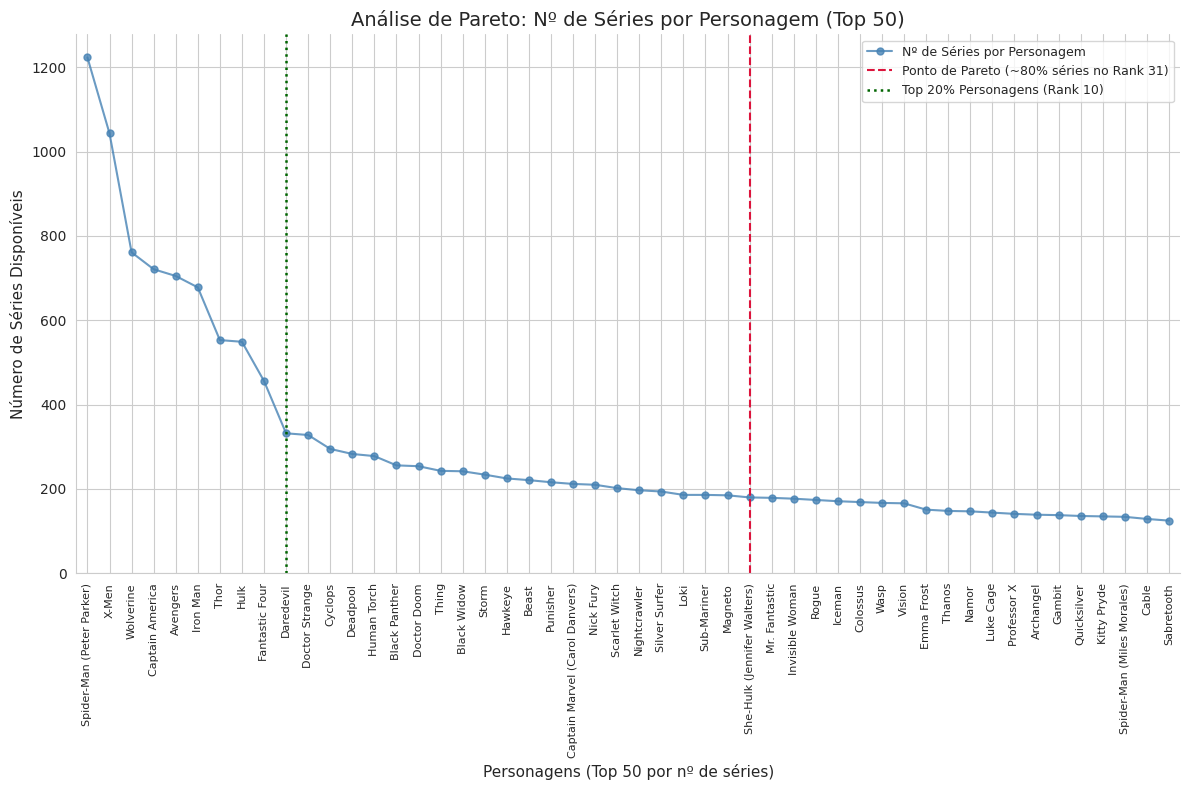

In [ ]:
def principio_pareto_series():
    conn = sqlite3.connect(DB_NAME)
    df_principio_pareto = pd.read_sql('''
    WITH
      top50 AS (
        SELECT
          id,
          name,
          series_available
        FROM characters
        ORDER BY series_available DESC
        LIMIT 50
      ),
      sum50 AS (
        SELECT SUM(series_available) AS total_series
        FROM top50
      )
    SELECT
      ROW_NUMBER() OVER (ORDER BY t.series_available DESC) AS rank,
      t.id,
      t.name,
      t.series_available,
      s.total_series AS total_series_top50,
      ROUND(
        t.series_available * 100.0 / s.total_series
      , 2) AS pct_individual,
      ROUND(
        SUM(t.series_available) OVER (
          ORDER BY t.series_available DESC
          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) * 100.0 / s.total_series
      , 2) AS pct_acumulada
    FROM top50 AS t
    CROSS JOIN sum50 AS s
    ORDER BY rank;
    ''', conn)
    conn.close()

    print("\n--- Amostra dos Dados da Análise de Pareto (Top 10) ---")
    print(df_principio_pareto[['rank', 'name', 'series_available', 'pct_acumulada']].head(10).to_string(index=False))
    return df_principio_pareto

# Carrega o DataFrame
# Se df_principio_pareto estiver vazio aqui, o código subsequente provavelmente falhará.
df_principio_pareto = principio_pareto_series()

# --- Gráfico de Pareto
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

line_color = 'steelblue'
ax.plot(df_principio_pareto['rank'].values,
        df_principio_pareto['series_available'],
        marker='o', markersize=5, linestyle='-', linewidth=1.5,
        color=line_color, alpha=0.8, label='Nº de Séries por Personagem')

# Ponto de 80% acumulado
pareto_highlight_color_80 = 'crimson'
pareto_point_80 = df_principio_pareto[df_principio_pareto['pct_acumulada'] >= 80].iloc[0]
rank_pareto_80 = pareto_point_80['rank']

ax.axvline(rank_pareto_80, color=pareto_highlight_color_80, linestyle='--', linewidth=1.5,
           label=f"Ponto de Pareto (~80% séries no Rank {int(rank_pareto_80)})")

# Linha para os 20% dos personagens (Top 10 de 50)
rank_20_percent_personagens = 10
color_20_percent_line = 'darkgreen'
ax.axvline(rank_20_percent_personagens,
           color=color_20_percent_line,
           linestyle=':',
           linewidth=1.8,
           label=f"Top 20% Personagens (Rank {rank_20_percent_personagens})")

# Ajustes dos eixos e títulos
ax.set_xlabel('Personagens (Top 50 por nº de séries)', fontsize=11)
ax.set_ylabel('Número de Séries Disponíveis', fontsize=11)
ax.set_title('Análise de Pareto: Nº de Séries por Personagem (Top 50)', fontsize=14)

ax.set_xticks(df_principio_pareto['rank'].values)
ax.set_xticklabels(df_principio_pareto['name'], rotation=90, ha='center', fontsize=8)

ax.legend(loc='upper right', fontsize=9)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5, right=df_principio_pareto['rank'].max() + 0.5)

sns.despine(fig=fig, ax=ax)
plt.tight_layout()
plt.show()

<ipython-input-26-7e2aba5675c7>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='num_comics', y='title', data=df_top_series, palette='viridis')


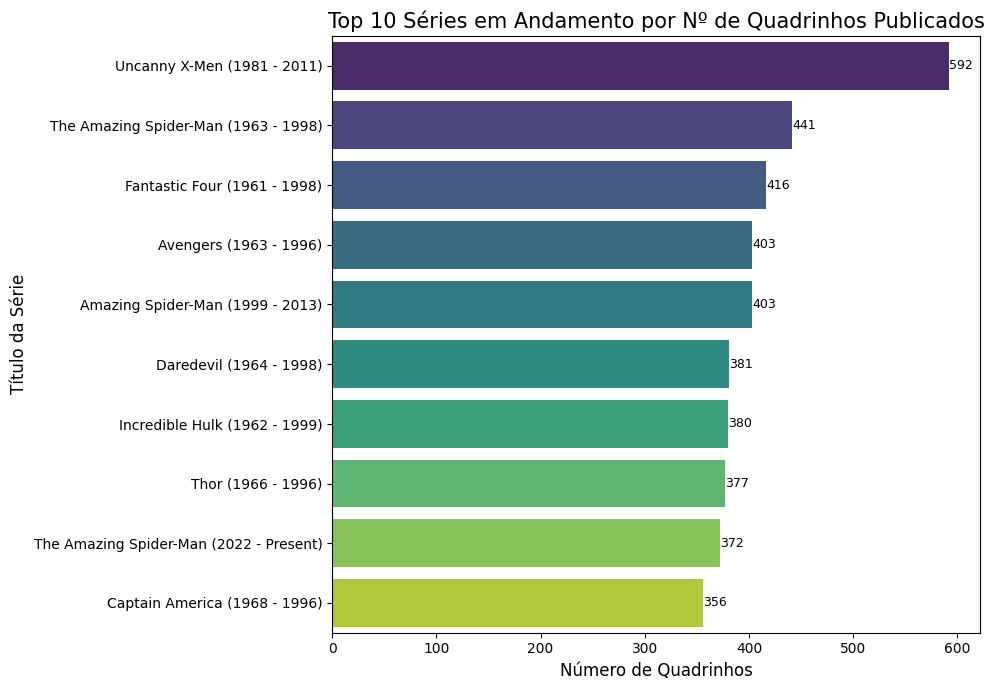

In [ ]:
def get_top_series_by_comics(limit=10):
    """Busca as top N séries por número de quadrinhos."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f'''
            SELECT s.title, COUNT(c.id) AS num_comics
            FROM comics c
            JOIN series s ON c.id_series = s.id
            GROUP BY s.title
            ORDER BY num_comics DESC
            LIMIT {limit}
        '''
        df = pd.read_sql_query(query, conn)
    return df

# --- Análise: Top Séries por Número de Quadrinhos ---
df_top_series = get_top_series_by_comics()


# Plotar gráfico
plt.figure(figsize=(10, 7))
# Usar uma paleta de cores e o barplot do seaborn
barplot = sns.barplot(x='num_comics', y='title', data=df_top_series, palette='viridis')

# Adicionar rótulos de dados às barras
for index, value in enumerate(df_top_series['num_comics']):
    barplot.text(value + 0.3,  # Posição x (valor + pequeno deslocamento para não sobrepor)
                  index,      # Posição y (índice da barra)
                  str(value), # Texto do rótulo
                  color='black', va='center', ha='left', fontsize=9)

plt.title('Top 10 Séries por Nº de Quadrinhos Publicados', fontsize=15)
plt.xlabel('Número de Quadrinhos', fontsize=12)
plt.ylabel('Título da Série', fontsize=12)
plt.tight_layout() # Ajusta o layout
plt.show()

<ipython-input-33-9c8ddcfaf1bf>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='num_variantes', y='serie', data=df_top_series, palette='viridis')


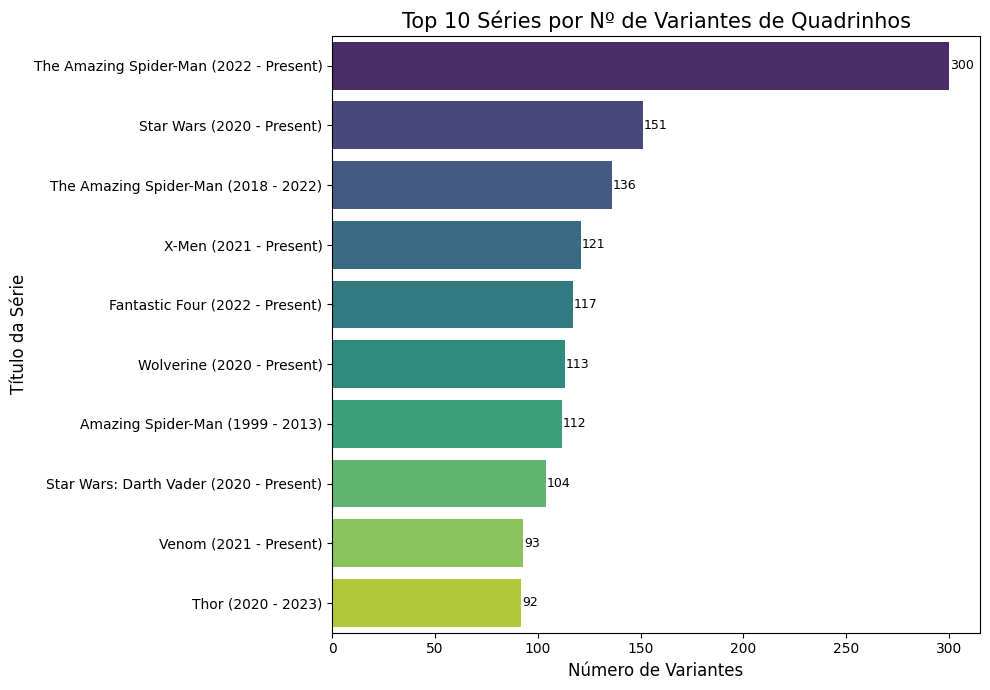

In [ ]:
def get_top_series_by_variants(limit=10):
    """Busca as top N séries por número de quadrinhos."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f'''
            SELECT s.title serie, COUNT(c.id) num_variantes
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description != ''
                        GROUP BY s.title
                        ORDER BY num_variantes DESC
                        LIMIT {limit}
        '''
        df = pd.read_sql_query(query, conn)
    return df

# --- Análise: Top Séries por Número de Quadrinhos ---
df_top_series = get_top_series_by_variants()


# Plotar gráfico
plt.figure(figsize=(10, 7))
# Usar uma paleta de cores e o barplot do seaborn
barplot = sns.barplot(x='num_variantes', y='serie', data=df_top_series, palette='viridis')

# Adicionar rótulos de dados às barras
for index, value in enumerate(df_top_series['num_variantes']):
    barplot.text(value + 0.3,  # Posição x (valor + pequeno deslocamento para não sobrepor)
                  index,      # Posição y (índice da barra)
                  str(value), # Texto do rótulo
                  color='black', va='center', ha='left', fontsize=9)

plt.title('Top 10 Séries por Nº de Variantes de Quadrinhos', fontsize=15)
plt.xlabel('Número de Variantes', fontsize=12)
plt.ylabel('Título da Série', fontsize=12)
plt.tight_layout() # Ajusta o layout
plt.show()

<ipython-input-34-35e01b01f80e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='num_issues', y='serie', data=df_top_series, palette='viridis')


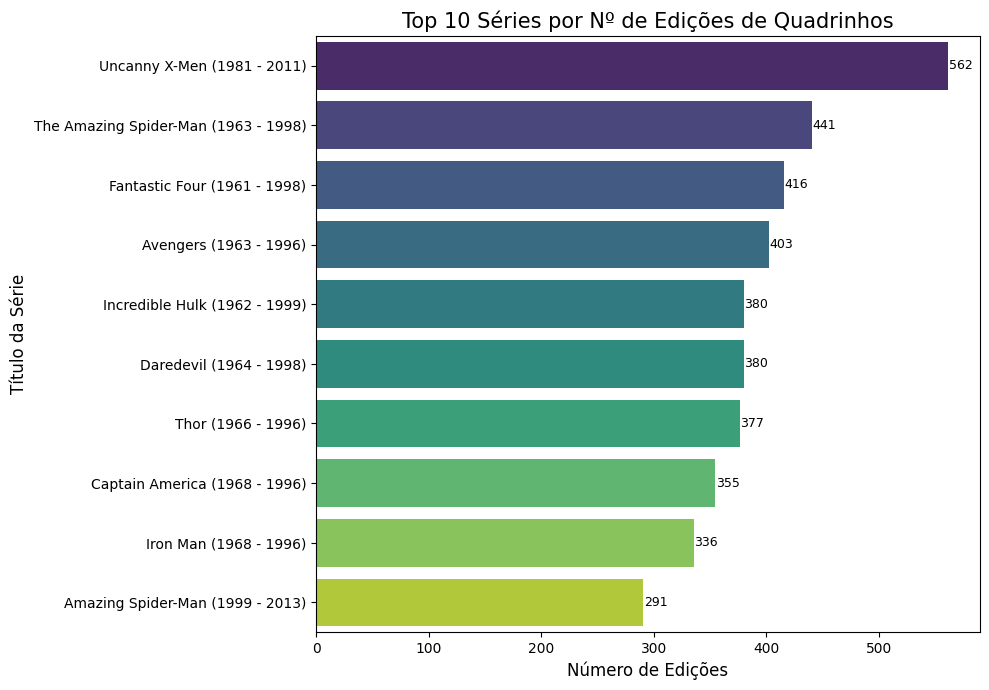

In [ ]:
def get_top_series_by_issues(limit=10):
    """Busca as top N séries por número de quadrinhos."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f'''
            SELECT s.title serie, COUNT(c.id) num_issues, ROUND(AVG(c.price),2) media_preco_issues
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description == '' AND issue_number != '' AND issue_number > 0
                        GROUP BY s.title
                        ORDER BY num_issues DESC
                        LIMIT {limit}
        '''
        df = pd.read_sql_query(query, conn)
    return df

# --- Análise: Top Séries por Número de Quadrinhos ---
df_top_series = get_top_series_by_issues()


# Plotar gráfico
plt.figure(figsize=(10, 7))
# Usar uma paleta de cores e o barplot do seaborn
barplot = sns.barplot(x='num_issues', y='serie', data=df_top_series, palette='viridis')

# Adicionar rótulos de dados às barras
for index, value in enumerate(df_top_series['num_issues']):
    barplot.text(value + 0.3,  # Posição x (valor + pequeno deslocamento para não sobrepor)
                  index,      # Posição y (índice da barra)
                  str(value), # Texto do rótulo
                  color='black', va='center', ha='left', fontsize=9)

plt.title('Top 10 Séries por Nº de Edições de Quadrinhos', fontsize=15)
plt.xlabel('Número de Edições', fontsize=12)
plt.ylabel('Título da Série', fontsize=12)
plt.tight_layout() # Ajusta o layout
plt.show()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


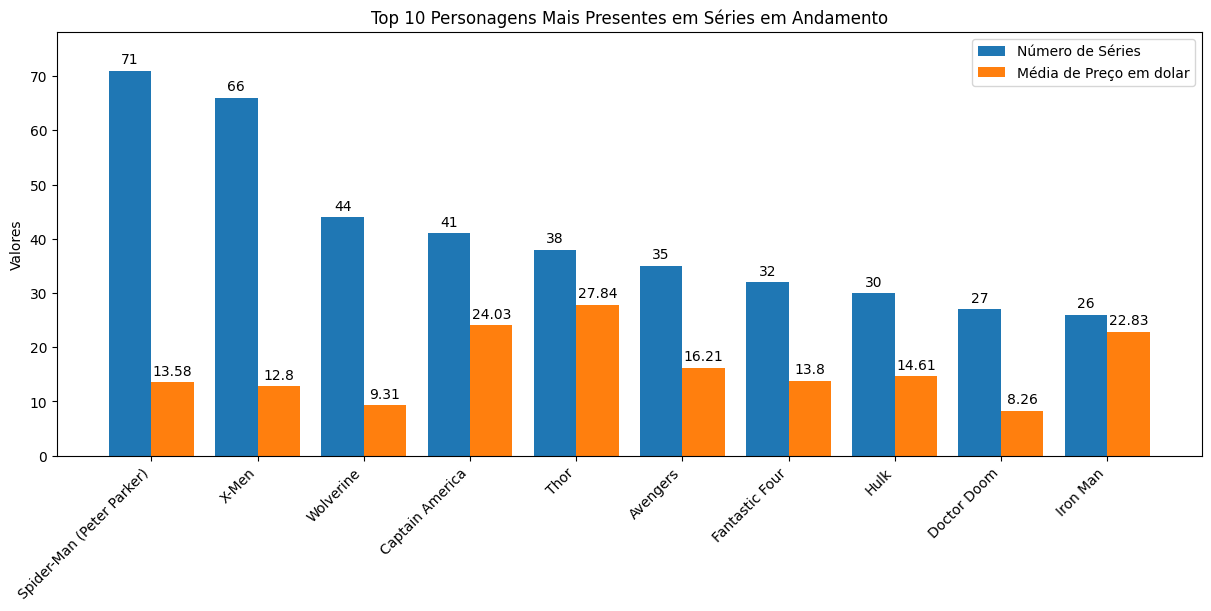

In [ ]:
#personagens que mais aparecem em series em andamento e a média de preço por serie desses personagens
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

df_personagens_mais_em_series = pd.DataFrame(show_table_sample())

# Preparando o gráfico
characters = df_personagens_mais_em_series['nome_personagem'].tolist()
attributes = ['num_series', 'media_preco']
labels = ['Número de Séries', 'Média de Preço em dolar']

x = np.arange(len(characters))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

for attr, label in zip(attributes, labels):
    offset = width * multiplier
    rects = ax.bar(x + offset, df_personagens_mais_em_series[attr], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Ajustes finais
ax.set_ylabel('Valores')
ax.set_title('Top 10 Personagens Mais Presentes em Séries em Andamento')
ax.set_xticks(x + width/2, characters, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, max(df_personagens_mais_em_series['num_series'].max(), df_personagens_mais_em_series['media_preco'].max()) * 1.1)

plt.show()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


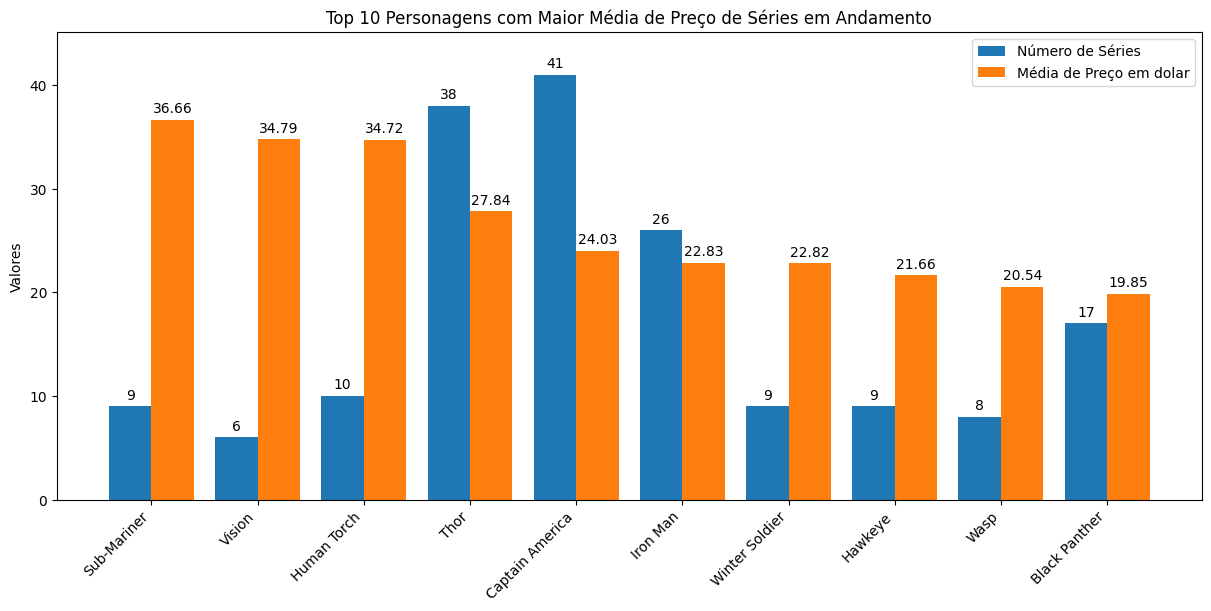

In [ ]:
#personagens que mais aparecem em series em andamento e a média de preço por serie desses personagens
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        HAVING num_series >5
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

df_personagens_mais_em_series = pd.DataFrame(show_table_sample())

# Preparando o gráfico
characters = df_personagens_mais_em_series['nome_personagem'].tolist()
attributes = ['num_series', 'media_preco']
labels = ['Número de Séries', 'Média de Preço em dolar']

x = np.arange(len(characters))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

for attr, label in zip(attributes, labels):
    offset = width * multiplier
    rects = ax.bar(x + offset, df_personagens_mais_em_series[attr], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Ajustes finais
ax.set_ylabel('Valores')
ax.set_title('Top 10 Personagens com Maior Média de Preço de Séries em Andamento')
ax.set_xticks(x + width/2, characters, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, max(df_personagens_mais_em_series['num_series'].max(), df_personagens_mais_em_series['media_preco'].max()) * 1.1)

plt.show()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


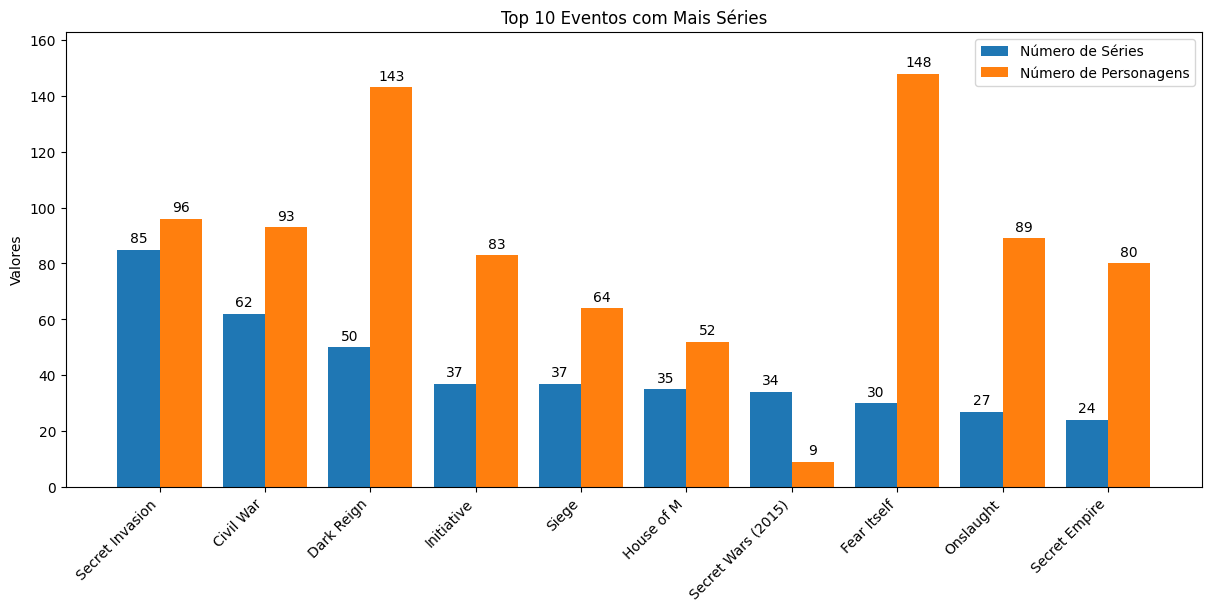

In [ ]:
#eventos com mais series e contagem de personagens
def top_events_series_with_characters():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH events_count_series as (
                        SELECT e.id, COUNT(es.id_serie) num_series
                        FROM events e JOIN  events_series es
                        ON e.id = es.id_event
                        GROUP BY e.id
                        ),

                        events_count_characters as (
                            SELECT e.id, COUNT(ce.id_character) num_characters
                        FROM events e JOIN characters_events ce
                        ON e.id = ce.id_event
                        GROUP BY e.id
                        )

                        SELECT e.title as evento, ecs.num_series, ecc.num_characters
                        FROM events e
                        JOIN events_count_series ecs
                        ON e.id = ecs.id
                        JOIN events_count_characters ecc
                        ON e.id = ecc.id
                        ORDER BY ecs.num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

df_grafico_eventos = top_events_series_with_characters()
events = df_grafico_eventos['evento'].tolist()
attributes = ['num_series', 'num_characters']
labels = ['Número de Séries', 'Número de Personagens']

x = np.arange(len(events))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

for attr, label in zip(attributes, labels):
    offset = width * multiplier
    rects = ax.bar(x + offset, df_grafico_eventos[attr], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Ajustes finais
ax.set_ylabel('Valores')
ax.set_title('Top 10 Eventos com Mais Séries')
ax.set_xticks(x + width/2, events, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, max(df_grafico_eventos['num_series'].max(), df_grafico_eventos['num_characters'].max()) * 1.1)

plt.show()


Estatísticas descritivas do número de séries associadas por evento:
count    68.000000
mean     14.088235
std      14.602939
min       1.000000
25%       4.000000
50%       9.500000
75%      17.000000
max      85.000000


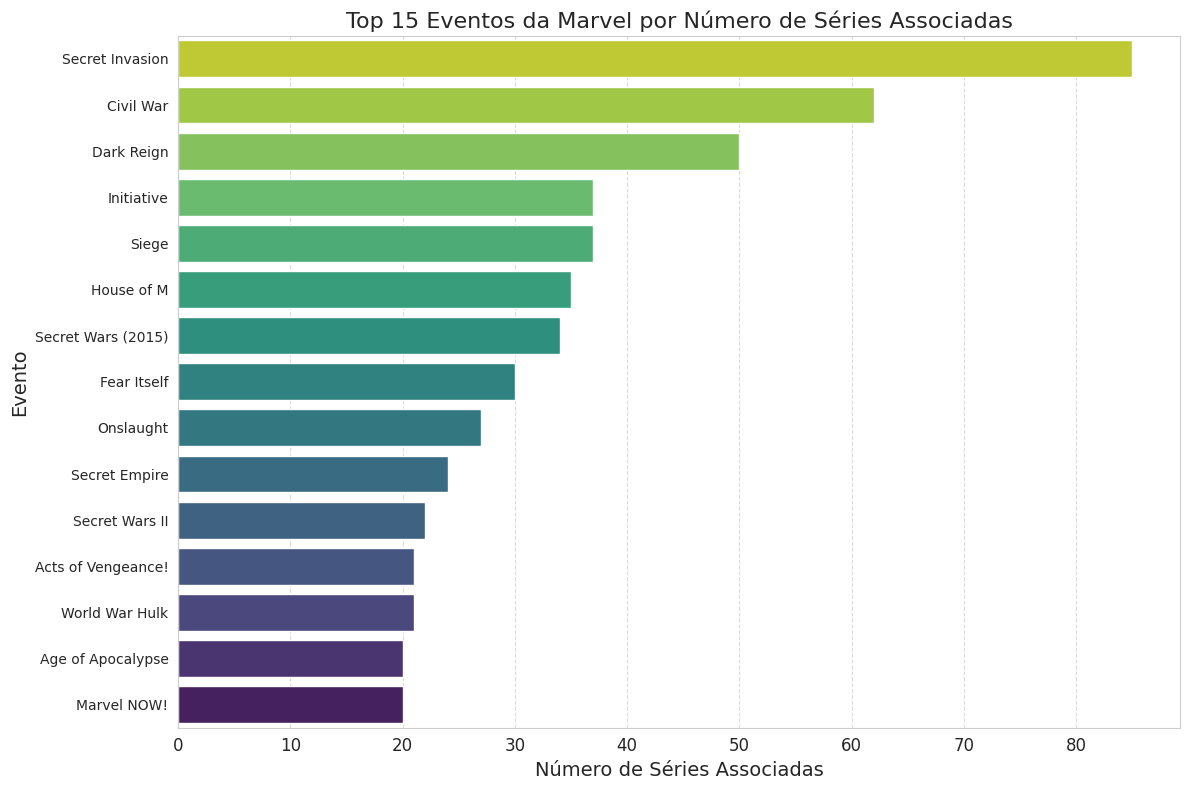

In [ ]:
def fetch_all_events_by_series_count_sorted():
    """
    Busca TODOS os eventos e o número de séries de quadrinhos associadas,
    ordenados pelo número de séries.
    """
    conn = sqlite3.connect(DB_NAME)
    query = """
    SELECT
        e.title AS event_title,
        COUNT(DISTINCT es.id_serie) AS num_series_associated
    FROM
        events e
    JOIN
        events_series es ON e.id = es.id_event
    WHERE e.title IS NOT NULL AND e.title != '' -- Evitar eventos sem título
    GROUP BY
        e.id, e.title  -- Agrupar por ID do evento para contagem correta
    ORDER BY
        num_series_associated DESC;
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

df_all_events_series = fetch_all_events_by_series_count_sorted()

print("\nEstatísticas descritivas do número de séries associadas por evento:")
print(df_all_events_series['num_series_associated'].describe().to_string())

# Para alterar a quantidade de linhas na tabela altere o valor top_n
top_n = 15
df_top_n_events_series = df_all_events_series.head(top_n)

# Gráfico de Barras Horizontais: Top N Eventos por Número de Séries Associadas
plt.figure(figsize=(12, 8))
# Aplicando a correção para o FutureWarning do Seaborn ao usar palette
barplot = sns.barplot(
    data=df_top_n_events_series,
    x='num_series_associated',
    y='event_title',
    palette='viridis_r', # Usando uma paleta invertida (maior valor com cor mais "forte")
    hue='event_title',   # Atribuir 'y' a 'hue' para aplicar a paleta por barra
    dodge=False,         # Evitar que as barras se "esquivem"
    legend=False         # Legenda redundante neste caso
)

# Adicionar rótulos de dados nas barras para clareza
for index, row in df_top_n_events_series.iterrows():
    value = row['num_series_associated']

    y_pos = df_top_n_events_series['event_title'].tolist().index(row['event_title'])

plt.title(f'Top {top_n} Eventos da Marvel por Número de Séries Associadas', fontsize=16)
plt.xlabel('Número de Séries Associadas', fontsize=14)
plt.ylabel('Evento', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

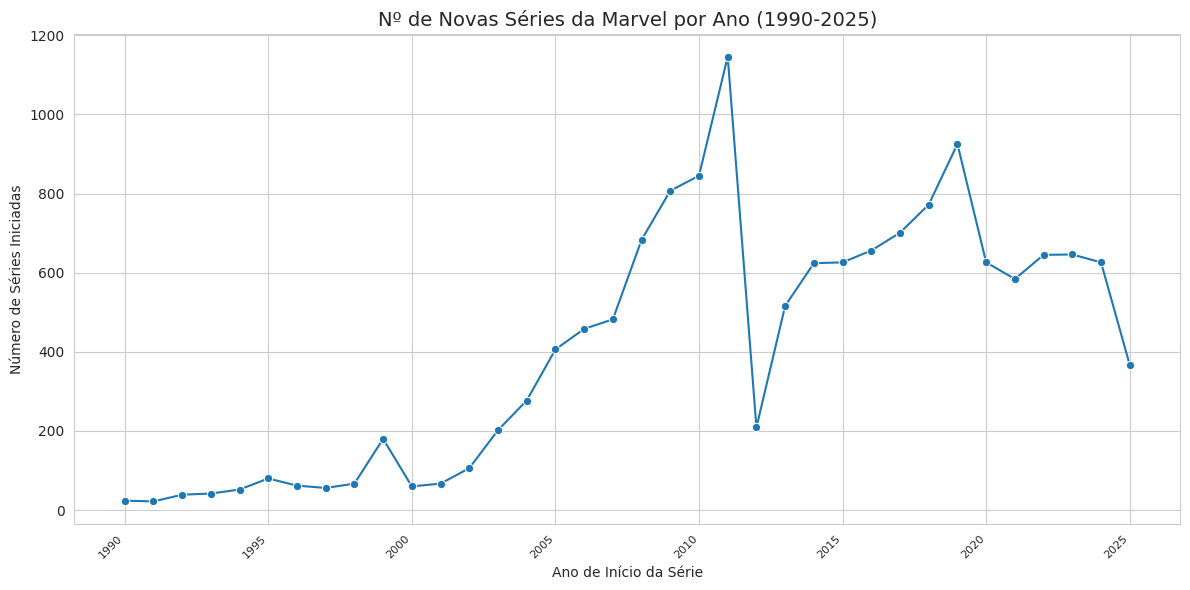

In [ ]:
def fetch_series_started_by_year_filtered():
    """Busca o número de séries iniciadas por ano, dentro de um intervalo."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f"""
            SELECT
                start_year,
                COUNT(DISTINCT id) AS num_series_started
            FROM
                series
            WHERE
                start_year IS NOT NULL
                AND start_year >= 1990
                AND start_year <= 2025
            GROUP BY
                start_year
            ORDER BY
                start_year ASC;
        """
        df = pd.read_sql_query(query, conn)
    return df

df_series_by_year_filtered = fetch_series_started_by_year_filtered()

# Plotar o gráfico apenas se houver dados
if not df_series_by_year_filtered.empty:
    plt.figure(figsize=(12, 6)) # Tamanho razoável para o gráfico
    sns.set_style("whitegrid") # Estilo limpo

    sns.lineplot(
        data=df_series_by_year_filtered,
        x='start_year',
        y='num_series_started',
        marker='o',       # Adiciona marcadores para destacar os anos
        linewidth=1.5     # Espessura da linha
    )

    plt.title(f'Nº de Novas Séries da Marvel por Ano (1990-2025)', fontsize=14)
    plt.xlabel('Ano de Início da Série', fontsize=10)
    plt.ylabel('Número de Séries Iniciadas', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8) # Rotação para melhor leitura dos anos
    plt.yticks(fontsize=10)


    plt.tight_layout() # Ajusta o layout para não cortar os rótulos
    plt.show()


O Marvel NOW! foi um grande relançamento da linha editorial da Marvel Comics que começou no final de 2012, após a conclusão do evento "Avengers vs. X-Men". A maior parte das novas séries e novas equipes criativas associadas a essa iniciativa tiveram seus lançamentos e consolidação ao longo de 2013.